In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import lightgbm as lgb
import datetime

In [3]:
nasdaq_stock_list=pd.read_csv("../nasdaq_screener_1638116717290.csv")

In [4]:
stock_list=["AAPL","BNTX","MRNA","ABCL"]

In [5]:
def get_daily_stocks_data(stock_list,start,end):
    data = yf.download(stock_list, start=start, end=end,group_by="ticker")
    tmp=pd.DataFrame(columns=["ticker",'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    for stock in stock_list:
        subset=data[stock].copy()
        subset["ticker"]=stock
        tmp=tmp.append(subset)
    return tmp

In [6]:
nasdaq_stock_list[nasdaq_stock_list["Market Cap"]>1000000000]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$152.07,-0.9000,-0.588%,4.603504e+10,United States,1999.0,1632227,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,$47.95,-2.5100,-4.974%,8.971596e+09,NaN,2016.0,7291156,Basic Industries,Metal Fabrications
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$9.80,-0.0175,-0.178%,1.225000e+09,NaN,2021.0,278790,Finance,Business Services
12,AAL,American Airlines Group Inc. Common Stock,$17.75,-1.7100,-8.787%,1.149338e+10,United States,NaN,84177492,Transportation,Air Freight/Delivery Services
17,AAON,AAON Inc. Common Stock,$78.09,-0.6400,-0.813%,4.094105e+09,United States,NaN,392310,Capital Goods,Industrial Machinery/Components
...,...,...,...,...,...,...,...,...,...,...,...
8127,ZTO,ZTO Express (Cayman) Inc. American Depositary ...,$30.85,-0.5900,-1.877%,2.494063e+10,China,2016.0,3452970,Transportation,Advertising
8129,ZTS,Zoetis Inc. Class A Common Stock,$219.32,-3.8500,-1.725%,1.037660e+11,United States,2013.0,976493,Health Care,Biotechnology: Pharmaceutical Preparations
8130,ZUMZ,Zumiez Inc. Common Stock,$47.33,-2.3900,-4.807%,1.186042e+09,United States,2005.0,251373,NaN,NaN
8131,ZUO,Zuora Inc. Class A Common Stock,$19.72,-0.4200,-2.085%,2.457112e+09,NaN,2018.0,524084,Technology,EDP Services


<AxesSubplot:>

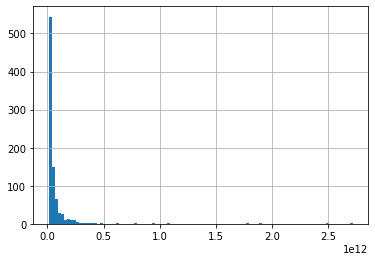

In [7]:
nasdaq_stock_list[nasdaq_stock_list["Market Cap"]>10000000000]["Market Cap"].hist(bins=100)

In [8]:
def get_metrics(stocks_data):
    #intra day variability
    metrics=stocks_data.groupby("ticker",as_index=False).agg(
        std_close=("Close","std"),
        avg_close=("Close","mean"),
    )
    metrics["std_pct"]=100*metrics.std_close/metrics.avg_close
    return metrics

In [9]:
def build_dataset(nasdaq_stock_list,start):
    yesterday=datetime.datetime.today()-datetime.timedelta(days=1)
    yesterday=yesterday.date()
    yesterday.isoformat()
    data=get_daily_stocks_data(
        stock_list=list(nasdaq_stock_list[nasdaq_stock_list["Market Cap"]>10000000000].Symbol.values),
        start=start,
        end=yesterday)
    data=data.dropna()
    metrics=get_metrics(data)
    data=data.reset_index(drop=False).rename({"index":"date"},axis="columns").drop(["Open","High","Low","Adj Close"],axis=1)
    data=data.merge(metrics,on="ticker",how="left")
    nasdaq_stock_list=nasdaq_stock_list.rename(
        {"Symbol":"ticker",
         "Market Cap":"market_capitalisation",
         "Country":"country",
         "IPO Year":"ipo_year",
         "Sector":"sector",
         "Industry":"industry"
        },axis="columns")[["ticker","market_capitalisation","country","ipo_year","sector","industry"]]
    data=data.merge(nasdaq_stock_list,on="ticker",how="left")
    data["date"]=pd.to_datetime(data.date)
    return data

In [10]:
data=build_dataset(nasdaq_stock_list,start="2019-01-01")

[*********************100%***********************]  881 of 881 completed


In [11]:
data["dom"]=data["date"].dt.day
data["dow"]=data.date.dt.dayofweek
data["woy"]=data.date.dt.isocalendar().week
data["moy"]=data.date.dt.month

In [12]:
data.to_csv("data.csv",index=False)

In [13]:
data=pd.read_csv("data.csv")
data["date"]=pd.to_datetime(data["date"])

In [14]:
from sktime.forecasting.arima import AutoARIMA

In [15]:
split_val=datetime.datetime.strptime('2021-06-30', '%Y-%m-%d')
split_test=datetime.datetime.strptime('2021-10-30', '%Y-%m-%d')

In [16]:
from prophet import Prophet
def fit_prophet(data,ticker,split_val):
    forecaster =  Prophet(seasonality_mode='multiplicative')
    forecaster.fit(data[(data.ticker==ticker)&(data.date<=split_val)][["date","Close"]].rename({"date":"ds","Close":"y"},axis="columns"))
    pred=forecaster.predict(data[(data.ticker==ticker)][["date"]].rename({"date":"ds"},axis="columns"))
    pred=pred[["ds","yhat","yhat_lower","yhat_upper"]].rename({"ds":"date"},axis="columns")
    pred["date"]=pd.to_datetime(pred["date"])
    pred["ticker"]=ticker
    # data=data.merge(pred,on=["date","ticker"],how="left")
    return pred

In [17]:
def apply_prophet(data,split_val):
    data=data.copy()
    res=pd.DataFrame(columns=["date","ticker","yhat","yhat_lower","yhat_upper"])
    for ticker in data.ticker.unique():
        try:
            print(ticker)
            pred=fit_prophet(data,ticker,split_val=split_val)
            res=res.append(pred) 
        except:
            continue
    data=data.merge(res,on=["date","ticker"],how="left")
    return data

In [18]:
data=apply_prophet(data,split_val=split_val)

A


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AAL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AAP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AAPL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ABB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ABBV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ABC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ABEV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ABMD


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ABNB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ABT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ACGL


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ACI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ACM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ACN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ADBE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ADI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ADM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ADP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ADSK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AEE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AEM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AEP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AER


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AES


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AFG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AFL


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AFRM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AGR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AIG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AJG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AKAM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALGN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALLE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALLY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ALNY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMAT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMCR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AME


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMGN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMOV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AMZN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ANET


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ANSS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ANTM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AON


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AOS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


APD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


APH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


APO


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


APP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


APTV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ARE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ARES


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ARGX


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ASAN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ASML


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ASX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ATH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ATO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ATVI


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AUR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AVB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AVGO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AVLR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AVTR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AVY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AWK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AXON


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AXP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AZN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AZO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BABA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BAC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BAH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BAM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BAX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BBD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BBDO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BBL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BBVA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BBWI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BBY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BCE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BCS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BDX


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BEKE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BEN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BGNE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BHP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BIDU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BIIB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BILI


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BILL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BIO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BIP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BKI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BKNG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BKR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BLDR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BLK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BLL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BMO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BMRN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BMY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BNS


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BNTX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BRKR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BRO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BSBR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BSX


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BSY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BTI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BUD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BURL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BWA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BXP


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.


BZ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


C


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CABO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CAG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CAH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CAJ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CAR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CARR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CAT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CBOE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CBRE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCEP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CCL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CDAY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CDNS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CDW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CERN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CFG


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.


CFLT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CGNX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CHD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CHKP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CHRW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CHT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CHTR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CHWY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CINF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CLF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CLR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CLVT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CLX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CMA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CMCSA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CME


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CMG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CMI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CMS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CNA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CNC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CNHI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CNI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CNP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CNQ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


COF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


COHR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


COIN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CONE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


COO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


COP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


COST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


COUP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPB


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPNG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPRT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CQP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CRH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CRL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CRM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CRWD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CSCO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CSGP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CSL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CSX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CTAS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CTLT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CTRA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CTSH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CTVA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CTXS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CUBE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CUK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CVE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CVNA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CVS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CVX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CZR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


D


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DAL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DAR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DASH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DD


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DDOG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DECK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DELL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DEO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DFS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DGX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DHI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DHR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DIDI
DIS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DISCA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DISCB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DISCK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DISH


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DKNG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DKS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DLR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DLTR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DNA
DOCN


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.


DOCS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DOCU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DOV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DOW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DPZ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DRE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DRI


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DTE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DUK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DVN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DXCM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EBAY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ECL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ED


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EFX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EIX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ELAN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ELP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ELS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EMN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EMR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ENB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ENIA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ENPH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ENTG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EOG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EPAM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EPD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EQH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EQIX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EQNR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EQR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ERIC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ERIE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ES


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ESS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ESTC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ET


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ETN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ETR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ETSY


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EVGO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EVRG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EWBC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EXAS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EXC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EXPD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EXPE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


EXR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


F


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FANG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FAST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FBHS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FCX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FDS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FDX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FERG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FFIV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FIS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FISV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FITB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FIVE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FLT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FMS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FMX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FND


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FNF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FNV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FOX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FOXA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FRC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FSLR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FTCH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FTNT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FTS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FTV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FWONA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


FWONK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GDDY


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GDRX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GDS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GE


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GFL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GFS
GGG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GIB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GILD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GIS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GLOB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GLPI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GLW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GMAB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GME


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GNRC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GOLD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GOOG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GOOGL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GPC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GPN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GRMN


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GRUB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GSK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GTLB
GWW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


GXO
HAL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HAS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HBAN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HCA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HDB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HEI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HES


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HIG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HLT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HOLX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HON


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HOOD
HPE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HPQ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HRC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HRL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HSBC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HSIC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HSY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HTHT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HTZ
HUBB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HUBS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HUM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HWM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HZNP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IAC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IBM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IBN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ICE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ICL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ICLR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IDXX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IEP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IEX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IFF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IHG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ILMN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IMO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INCY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ING


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INTC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INTU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INVH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IPG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IQV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IRM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ISRG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ITUB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ITW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IVZ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


IX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


J


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JBHT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JCI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JHX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JKHY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JLL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JNJ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JNPR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


JPM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


K


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KDP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KEP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KEY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KEYS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KHC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KIM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KKR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KLAC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KMB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KMI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KMX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KSU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


L


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LAMR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LBRDA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LBRDK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LBTYA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LBTYB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LBTYK


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LCID


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LDOS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LEA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LEN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LEVI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LFC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LHX


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LII


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LIN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LKQ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LLY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LMT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LNC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LNG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LNT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LOGI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LOW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LPLA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LRCX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LSCC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LSI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LSXMA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LSXMB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LSXMK


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LULU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LUMN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LUV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LVS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LYB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LYFT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LYG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


LYV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MASI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MCD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MCHP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MCK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MCO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MDB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MDLZ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MDT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MELI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MET


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MFC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MFG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MGA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MGM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MHK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MIDD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MKC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MKL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MKTX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MLM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MMM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MMP


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.


MNDY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MNST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MOH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MORN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MOS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MPC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MPLX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MPW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MPWR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.


MQ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MRK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MRNA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MRO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MRVL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSCI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSFT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MTB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MTCH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MTD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MTN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MUFG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NDAQ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NDSN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NEE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NEM


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NET


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NFLX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NGG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NICE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NIO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NKE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NLOK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NLY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NMR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NOC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NOK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NOW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NSC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NTAP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NTES


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NTR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NTRS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NUAN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NUE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NVAX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NVCR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NVDA


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NVEI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NVO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NVR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NVS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NWG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NWS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NWSA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NXPI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


O


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ODFL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OKE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OKTA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OLPX
OMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ON


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ONON
OPEN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ORAN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ORCL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ORLY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OTEX


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OTIS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


OXY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PANW


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PATH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PAYC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PAYX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PBA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PBR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PCAR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PCG


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


PCOR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PCTY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PDD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PEAK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PEG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PEP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PFE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PFG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PGR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PHG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PHM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PINS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PKG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PKI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PKX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PLD


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PLTR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PLUG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PNC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PNR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PODD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


POOL


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PPD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PPG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PPL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PRU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PSA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PSX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PTC


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PTON


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PTR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PUK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PWR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PXD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


PYPL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


QCOM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


QGEN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


QRVO


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


QS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


QSR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RACE


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RBLX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RCI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RCL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RDY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


REG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


REGN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RELX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


REXR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RGEN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RHI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RIO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RIVN
RJF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RNG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ROK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ROKU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ROL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ROP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ROST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RPM


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RPRX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RRX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RSG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RTX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RYAAY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


S
SAN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SAP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SBAC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SBNY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SBUX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SCCO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SCHW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SCI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SEDG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SGEN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SHG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SHOP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SHW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SIRI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SITE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SIVB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SJM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SJR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SKM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SLB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SLF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SMFG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNAP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNN


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNOW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNPS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SNY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SO


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SOFI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SONY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SPG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SPGI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SPLK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SPOT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SQ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SQM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SRE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SSNC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


STE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


STLA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


STLD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


STM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


STT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


STX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


STZ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SUI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SUZ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SWK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SWKS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SYF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SYK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SYNA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SYNH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SYY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


T


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TAK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TCOM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TDG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TDOC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TDY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TEAM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TECH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TECK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TEF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TEL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TER


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TFC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TFII


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TFX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TGT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TJX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TLK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TME


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TMO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TMUS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TOST
TPR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TREX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRGP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRMB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TROW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TRV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TSCO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TSLA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TSM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TSN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TTC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TTD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TTE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TTM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TTWO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TU


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TWLO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TWTR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TXG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TXN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TXT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TYL


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


U


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UAA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UAL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UBER


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UBS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UDR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UHAL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ULTA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UNH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UNP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UPS


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UPST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


URI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


USB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


V


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VALE


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VEEV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VFC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VIAC


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VIACA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VICI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VIV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VLO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VMW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VOD


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VRSK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VRSN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VRTX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VTR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VTRS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


VZ


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


W


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WAB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WAL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WAT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WBA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WBK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WCN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WDAY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WDC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WEC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WELL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WFC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WHR


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WIT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WLK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WLTW


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WMB


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WMG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WMT


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WOLF


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WPC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WPM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WPP


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WRB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WRK


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WSM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WSO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WST


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WTRG


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XEL


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XLNX


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XOM


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XP


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XPEV


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XRAY


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XYL


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.


YMM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


YNDX


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


YUM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


YUMC


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Z


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZBH


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZBRA


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZEN


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZG


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZI


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZION


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZM


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZS


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZTO


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ZTS


In [32]:
def fit(data,ticker,split_val):
    forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
    forecaster.fit(y=data[(data.ticker==ticker)&(data.date<=split_val)].Close)
    train_pred=forecaster.predict(list(range(-len(data[(data.ticker==ticker)&(data.date<=split_val)].Close)+1,len(data[(data.ticker==ticker)&(data.date>split_val)+1]))))
    data.loc[(data.ticker==ticker),"autoarima"]=train_pred
    return data

<AxesSubplot:xlabel='date'>

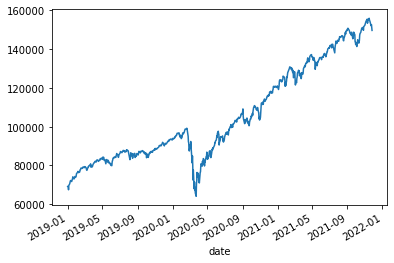

In [544]:
data.groupby("date").Close.sum().plot()

<AxesSubplot:xlabel='date'>

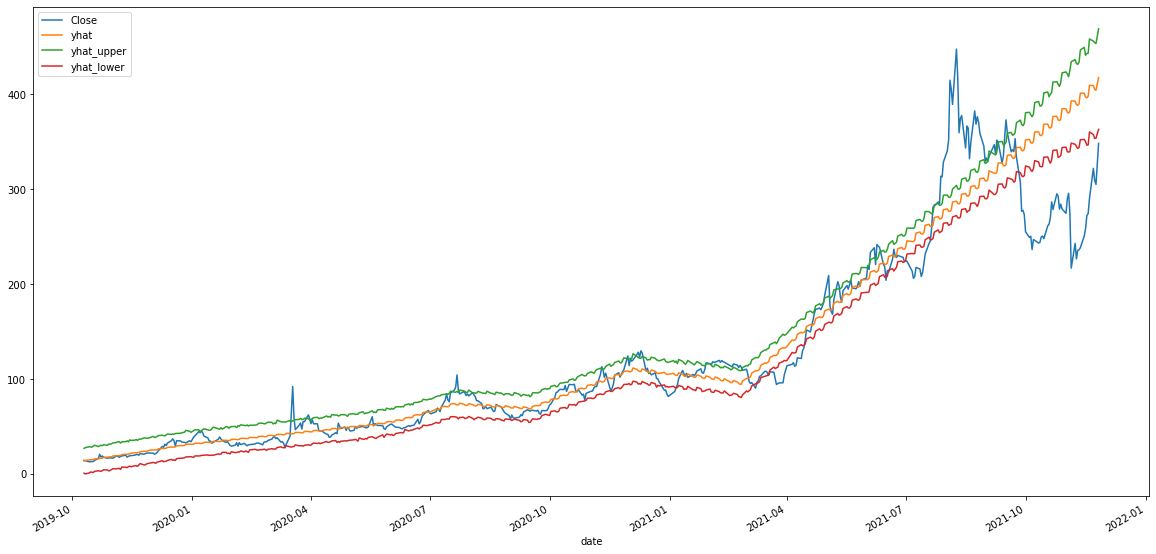

In [33]:
data[data.ticker=="BNTX"].plot(x="date",y=["Close","yhat","yhat_upper","yhat_lower"],figsize=(20,10))

In [511]:
from sklearn import preprocessing

def encode(data,categoricals):
    data=data.copy()
    enc={}
    new_categorical=[]
    for cat in categoricals:
        if data[cat].dtype not in ["int","float","bool"]:
            le = preprocessing.LabelEncoder()
            le.fit(data[cat])
            enc[cat]=le
            data[f"{cat}_enc"]=enc[cat].transform(data[cat])
            new_categorical.append(f"{cat}_enc")
        else:
            new_categorical.append(cat)
    return data,enc,new_categorical

In [512]:
categorical=['ticker', 'ipo_year', 'sector',
       'industry', 'dom', 'dow', 'woy', 'moy']
numerical=['std_close', 'avg_close','yhat',"yhat_upper","yhat_lower",
       'std_pct', 'market_capitalisation',
]
target="Close"

In [513]:
data_enc,encoders,categorical=encode(data,categorical)

In [515]:
categorical

['ticker_enc',
 'ipo_year',
 'sector_enc',
 'industry_enc',
 'dom_enc',
 'dow_enc',
 'woy_enc',
 'moy_enc']

In [516]:
train=data_enc[data_enc.date<split_val]
val=data_enc[data_enc.date.between(split_val,split_test)]
test=data_enc[data_enc.date>split_test]

In [517]:
avg_historical_metrics=train.groupby("ticker",as_index=False).agg(
    avg_hist_price=("Close","mean"),
    max_hist_price=("Close","max"),
    min_hist_price=("Close","min"),
    std_hist_price=("Close","std")
)

In [518]:
data_enc=data_enc.merge(avg_historical_metrics,on="ticker",how="left")


In [519]:
train=train.merge(avg_historical_metrics,on="ticker",how="left")
val=val.merge(avg_historical_metrics,on="ticker",how="left")
test=test.merge(avg_historical_metrics,on="ticker",how="left")

In [520]:
numerical.extend(["avg_hist_price","std_hist_price","max_hist_price","min_hist_price"])

In [521]:
y_train = train[target].values
y_val = val[target].values
X_train = train[categorical+numerical]
X_val = val[categorical+numerical]

In [522]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train,categorical_feature=categorical,free_raw_data = False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,categorical_feature=categorical,free_raw_data = False)

In [523]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    "n_estimators":1000,
    'objective': 'regression',
    'metric': {'l2','l1'},
    'num_leaves': 200,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'tree_learner':"feature",
    'max_bin':2000,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)

Starting training...


C:\Users\smaatoug\Miniconda3\envs\portfolio\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\smaatoug\Miniconda3\envs\portfolio\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 81822.2	valid_0's l1: 111.663
Training until validation scores don't improve for 50 rounds


C:\Users\smaatoug\Miniconda3\envs\portfolio\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\smaatoug\Miniconda3\envs\portfolio\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's l2: 67623.1	valid_0's l1: 100.919
[3]	valid_0's l2: 55999.7	valid_0's l1: 91.2564
[4]	valid_0's l2: 46432.5	valid_0's l1: 82.5551
[5]	valid_0's l2: 38700.5	valid_0's l1: 74.8264
[6]	valid_0's l2: 32322.3	valid_0's l1: 67.9211
[7]	valid_0's l2: 27134.9	valid_0's l1: 61.7976
[8]	valid_0's l2: 22861.8	valid_0's l1: 56.3187
[9]	valid_0's l2: 19353.3	valid_0's l1: 51.442
[10]	valid_0's l2: 16459.7	valid_0's l1: 47.1282
[11]	valid_0's l2: 14062.7	valid_0's l1: 43.2924
[12]	valid_0's l2: 12099.7	valid_0's l1: 39.9109
[13]	valid_0's l2: 10463.7	valid_0's l1: 36.9211
[14]	valid_0's l2: 9101.97	valid_0's l1: 34.2933
[15]	valid_0's l2: 7977.3	valid_0's l1: 31.9753
[16]	valid_0's l2: 7038.17	valid_0's l1: 29.9404
[17]	valid_0's l2: 6253.59	valid_0's l1: 28.1578
[18]	valid_0's l2: 5608.31	valid_0's l1: 26.6045
[19]	valid_0's l2: 5068.84	valid_0's l1: 25.2568
[20]	valid_0's l2: 4609.47	valid_0's l1: 24.0704
[21]	valid_0's l2: 4225.7	valid_0's l1: 23.0457
[22]	valid_0's l2: 3907.43	vali

In [524]:
data_enc["pred"]=gbm.predict(data_enc[gbm.feature_name()])

<AxesSubplot:xlabel='date'>

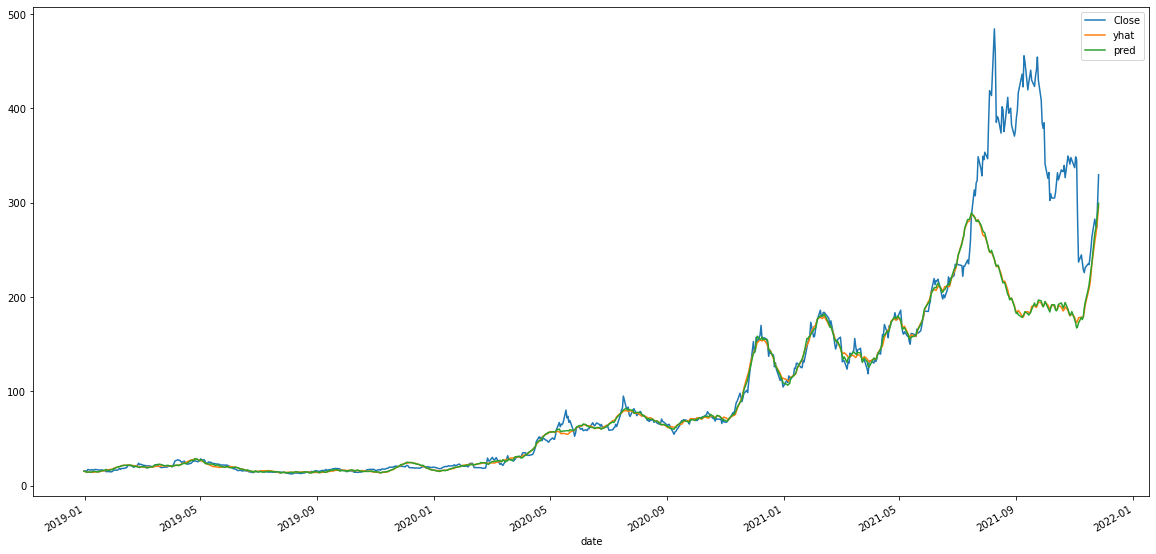

In [527]:
data_enc[data_enc.ticker=="MRNA"].plot(x="date",y=["Close","yhat","pred"],figsize=(20,10))

<AxesSubplot:xlabel='feature_name'>

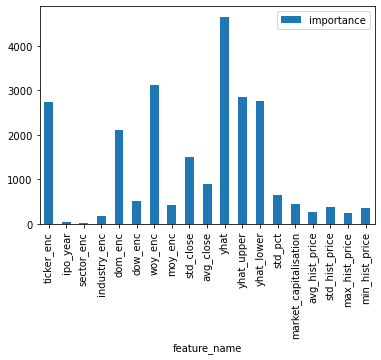

In [528]:
pd.DataFrame(zip(gbm.feature_name(),gbm.feature_importance()),columns=["feature_name","importance"]).plot.bar(x="feature_name",y="importance")

In [529]:
stocks=train.ticker.unique()

In [530]:
import numpy as np
def compute_metrics(data,model,stocks):
    test=data[data.ticker.isin(stocks)].copy()
    test["pred"]=model.predict(test[model.feature_name()])
    test["error"]=test.pred-test.Close
    test["error_by_actuals"]=test["error"]/test.Close
    test["abs_error"]=test.error.abs()
    test["abs_error_by_actuals"]=test["abs_error"]/test.Close
    test["error_fb"]=test.yhat-test.Close
    test["error_by_actuals_fb"]=test["error_fb"]/test.Close
    test["abs_error_fb"]=test.error_fb.abs()
    test["abs_error_by_actuals_fb"]=test["abs_error_fb"]/test.Close
    metrics=test.groupby("ticker",as_index=False).agg(
        avg_mk_cap=("market_capitalisation","mean"),
        std_stock=("Close","std"),
        mape=("abs_error_by_actuals",lambda x: np.round(100*np.average(x),2)),
        bias=("error_by_actuals",lambda x: np.round(100*np.average(x),2)),
        mape_fb=("abs_error_by_actuals_fb",lambda x: np.round(100*np.average(x),2)),
        bias_fb=("error_by_actuals_fb",lambda x: np.round(100*np.average(x),2))
    )
    return metrics

In [533]:
metrics=compute_metrics(test,gbm,stocks)

In [534]:
metrics.sort_values("mape")

,ticker,avg_mk_cap,std_stock,mape,bias,mape_fb,bias_fb
416,ITW,7.368350e+10,10.555610,1.45,0.51,2.04,-1.14
139,CARR,4.799147e+10,1.708807,1.66,0.26,2.28,2.05
262,ECL,6.483012e+10,7.648154,2.00,0.04,4.65,-4.54
599,PEAK,1.827455e+10,0.622257,2.03,1.11,2.02,-0.65
687,SJM,1.419016e+10,3.273359,2.04,-0.84,2.07,-0.58
...,...,...,...,...,...,...,...
194,CPNG,4.797198e+10,1.456458,154.43,154.43,80.45,80.45
609,PINS,2.791401e+10,4.915876,170.80,170.80,172.38,172.38
292,EVGO,3.626719e+10,3.473842,192.38,192.38,167.19,167.19
565,NVCR,1.007151e+10,6.383016,243.48,243.48,247.42,247.42


<AxesSubplot:>

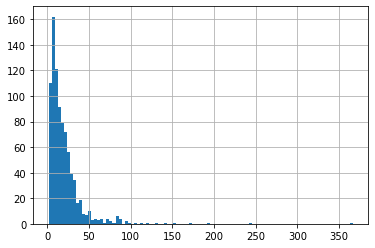

In [536]:
metrics.mape.hist(bins=100)

<AxesSubplot:xlabel='date'>

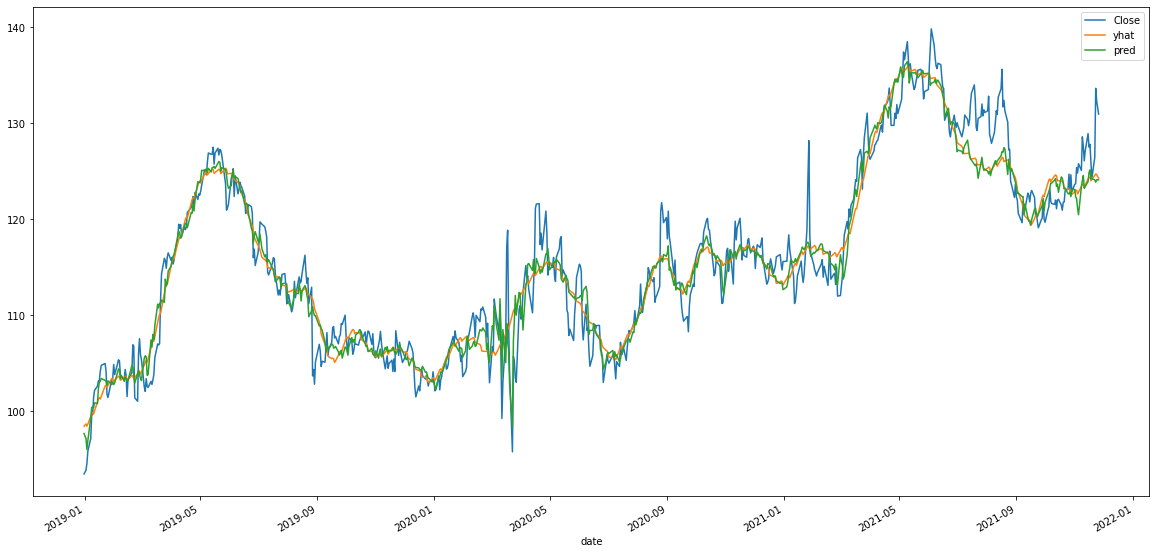

In [543]:
data_enc[data_enc.ticker=="SJM"].plot(x="date",y=["Close","yhat","pred",],figsize=(20,10))

In [508]:
data_enc.date.max()

Timestamp('2021-06-29 00:00:00')

In [498]:
def compute_return(test,model):
    test=test.copy()
    test["pred"]=model.predict(test[model.feature_name()])
    test_initial=test[test.date==test.date.min()][["ticker","date","Close"]].rename(columns={"date":"start_date","Close":"start_Close"})
    test_end=test[test.date==test.date.max()][["ticker","date","Close","pred"]].rename(columns={"date":"end_date","Close":"end_Close"})
    invest=test_initial.merge(test_end,on="ticker",how="inner")
    invest["expected_return_pct"]=100*invest["pred"]/invest["start_Close"]
    invest["actual_return_pct"]=100*invest["end_Close"]/invest["start_Close"]
    invest["expected_gain"]=invest["pred"]-invest["start_Close"]
    invest["actual_gain"]=invest["end_Close"]-invest["start_Close"]
    return invest

In [499]:
res=compute_return(test,gbm)

In [500]:
res.sort_values("actual_return_pct")

,ticker,start_date,start_Close,end_date,end_Close,pred,expected_return_pct,actual_return_pct,expected_gain,actual_gain
635,PTON,2021-10-01,86.709999,2021-11-26,46.410000,89.323830,103.014451,53.523239,2.613830,-40.299999
871,ZG,2021-10-01,91.400002,2021-11-26,55.070000,176.774416,193.407454,60.251640,85.374415,-36.330002
867,Z,2021-10-01,90.360001,2021-11-26,55.619999,148.796427,164.670679,61.553783,58.436426,-34.740002
702,SNAP,2021-10-01,75.250000,2021-11-26,49.759998,94.916559,126.134963,66.126244,19.666559,-25.490002
377,HOOD,2021-10-01,41.900002,2021-11-26,27.920000,2.556596,6.101661,66.634843,-39.343406,-13.980001
...,...,...,...,...,...,...,...,...,...,...
647,RBLX,2021-10-01,75.589996,2021-11-26,122.650002,110.400640,146.051918,162.256922,34.810643,47.060005
294,EVGO,2021-10-01,8.280000,2021-11-26,13.690000,32.823529,396.419445,165.338165,24.543529,5.410000
550,NET,2021-10-01,114.980003,2021-11-26,200.119995,112.926436,98.213979,174.047651,-2.053567,85.139992
458,LCID,2021-10-01,24.610001,2021-11-26,51.720001,16.829452,68.384608,210.158472,-7.780548,27.110001


In [502]:
res["error"]=res["expected_return_pct"]-res["actual_return_pct"]

<AxesSubplot:>

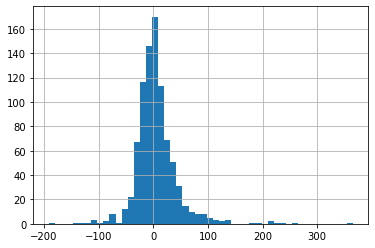

In [504]:
res["error"].hist(bins=50)

In [371]:
from datetime import timedelta

In [475]:
def model_return(data,weeks=4):
    data_return=data.copy()
    data_4w=data_return[["ticker","date","Close","yhat"]].copy()
    data_4w["date"]=data_4w.date-timedelta(weeks=weeks)
    data_4w=data_4w.rename(columns={"Close":"Close_30","yhat":"yhat_30"})
    data_return=data_return.merge(data_4w,on=["ticker","date"],how="inner")
    data_return["return"]=data_return.Close_30/data_return.Close
    data_return["fb_return"]=data_return.yhat_30/data_return.yhat
    data_return["direction"]=data_return["return"].apply(lambda x: 1 if x>1 else 0)
    split_val=datetime.datetime.strptime('2021-06-30', '%Y-%m-%d')
    split_test=datetime.datetime.strptime('2021-09-30', '%Y-%m-%d')
    categorical=['ticker', 
                 #'ipo_year',
                 'sector',
           'industry',
                 'dom',
                 #'dow',
                 'woy', 'moy']
    numerical=['std_close', 'avg_close',
                #'yhat',"yhat_upper","yhat_lower",
               #"fb_return",
           'std_pct', 'market_capitalisation',
    ]
    target="direction"
    data_enc,encoders,categorical=encode(data_return,categorical)
    train=data_enc[data_enc.date<split_val]
    val=data_enc[data_enc.date.between(split_val,split_test)]
    test=data_enc[data_enc.date>split_test]
    avg_historical_metrics=train.groupby("ticker",as_index=False).agg(
        avg_hist_return=("direction","mean"),
        avg_hist_price=("Close","mean"),
        max_hist_price=("Close","max"),
        min_hist_price=("Close","min"),
        std_hist_price=("Close","std")
    )
    data_enc=train.merge(avg_historical_metrics,on="ticker",how="left")
    train=train.merge(avg_historical_metrics,on="ticker",how="left")
    val=val.merge(avg_historical_metrics,on="ticker",how="left")
    test=test.merge(avg_historical_metrics,on="ticker",how="left")
    numerical.extend(["avg_hist_return","min_hist_return","max_hist_return","avg_hist_price","std_hist_price","max_hist_price","min_hist_price"])
    y_train = train[target].values
    y_val = val[target].values
    X_train = train[categorical+numerical]
    X_val = val[categorical+numerical]
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train,categorical_feature=categorical,free_raw_data = False)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,categorical_feature=categorical,free_raw_data = False)
    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        "n_estimators":100,
        'objective': 'binary',
        'metric': {'auc','l2','l1'},
        'max_depth':10,
        'num_leaves': 200,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        #'bagging_fraction': 0.8,
        # 'bagging_freq': 5,
        #'tree_learner':"feature",
        'max_bin':2000,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=50)
    return gbm

In [476]:
model=model_return(data,weeks=4)

KeyError: "['min_hist_return', 'max_hist_return'] not in index"

In [462]:
model.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.5619680884503943),
                          ('l2', 0.24824151318640636),
                          ('l1', 0.48850093559973556)])})

In [370]:
data_return=data.copy()

In [372]:
data_4w=data_return[["ticker","date","Close","yhat"]].copy()

In [373]:
data_4w["date"]=data_4w.date-timedelta(weeks=4)

In [374]:
data_4w=data_4w.rename(columns={"Close":"Close_30","yhat":"yhat_30"})

In [375]:
data_return=data_return.merge(data_4w,on=["ticker","date"],how="inner")

In [406]:
data_return["return"]=data_return.Close_30/data_return.Close
data_return["fb_return"]=data_return.yhat_30/data_return.yhat

In [434]:
data_return["direction"]=data_return["return"].apply(lambda x: 1 if x>1 else 0)

In [435]:
split_val=datetime.datetime.strptime('2021-06-30', '%Y-%m-%d')
split_test=datetime.datetime.strptime('2021-09-30', '%Y-%m-%d')

In [436]:
categorical=['ticker', 'ipo_year', 'sector',
       'industry', 'dom', 'dow', 'woy', 'moy']
numerical=['std_close', 'avg_close',
            'yhat',"yhat_upper","yhat_lower",
           "fb_return",
       'std_pct', 'market_capitalisation',
]
target="direction"

In [437]:
from sklearn import preprocessing

def encode(data,categoricals):
    data=data.copy()
    enc={}
    new_categorical=[]
    for cat in categoricals:
        if data[cat].dtype not in ["int","float","bool"]:
            le = preprocessing.LabelEncoder()
            le.fit(data[cat])
            enc[cat]=le
            data[f"{cat}_enc"]=enc[cat].transform(data[cat])
            new_categorical.append(f"{cat}_enc")
        else:
            new_categorical.append(cat)
    return data,enc,new_categorical

In [438]:
data_enc,encoders,categorical=encode(data_return,categorical)

In [439]:
train=data_enc[data_enc.date<split_val]
val=data_enc[data_enc.date.between(split_val,split_test)]
test=data_enc[data_enc.date>split_test]

In [440]:
avg_historical_metrics=train.groupby("ticker",as_index=False).agg(
    avg_hist_return=("return","mean"),
    max_hist_return=("return","max"),
    min_hist_return=("return","min"),
    avg_hist_price=("Close","mean"),
    max_hist_price=("Close","max"),
    min_hist_price=("Close","min"),
    std_hist_price=("Close","std")
)

In [441]:
data_enc=train.merge(avg_historical_metrics,on="ticker",how="left")


In [442]:
train=train.merge(avg_historical_metrics,on="ticker",how="left")
val=val.merge(avg_historical_metrics,on="ticker",how="left")
test=test.merge(avg_historical_metrics,on="ticker",how="left")

In [443]:
numerical.extend(["avg_hist_return","min_hist_return","max_hist_return","avg_hist_price","std_hist_price","max_hist_price","min_hist_price"])

In [444]:
y_train = train[target].values
y_val = val[target].values
X_train = train[categorical+numerical]
X_val = val[categorical+numerical]

In [445]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train,categorical_feature=categorical,free_raw_data = False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,categorical_feature=categorical,free_raw_data = False)

In [448]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    "n_estimators":100,
    'objective': 'binary',
    'metric': {'auc','l2','l1'},
    'num_leaves': 200,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    #'tree_learner':"feature",
    'max_bin':2000,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                #num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's auc: 0.521852	valid_0's l2: 0.251737	valid_0's l1: 0.489558
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.523374	valid_0's l2: 0.251463	valid_0's l1: 0.489563
[3]	valid_0's auc: 0.524175	valid_0's l2: 0.251201	valid_0's l1: 0.489553
[4]	valid_0's auc: 0.52398	valid_0's l2: 0.250983	valid_0's l1: 0.489559
[5]	valid_0's auc: 0.524076	valid_0's l2: 0.25079	valid_0's l1: 0.489569
[6]	valid_0's auc: 0.524147	valid_0's l2: 0.250618	valid_0's l1: 0.489566
[7]	valid_0's auc: 0.524511	valid_0's l2: 0.250465	valid_0's l1: 0.489556
[8]	valid_0's auc: 0.524582	valid_0's l2: 0.250346	valid_0's l1: 0.489548
[9]	valid_0's auc: 0.524569	valid_0's l2: 0.250245	valid_0's l1: 0.489542
[10]	valid_0's auc: 0.524706	valid_0's l2: 0.25017	valid_0's l1: 0.489531
[11]	valid_0's 

In [327]:
data_enc["pred"]=gbm.predict(data_enc[gbm.feature_name()])

<AxesSubplot:xlabel='date'>

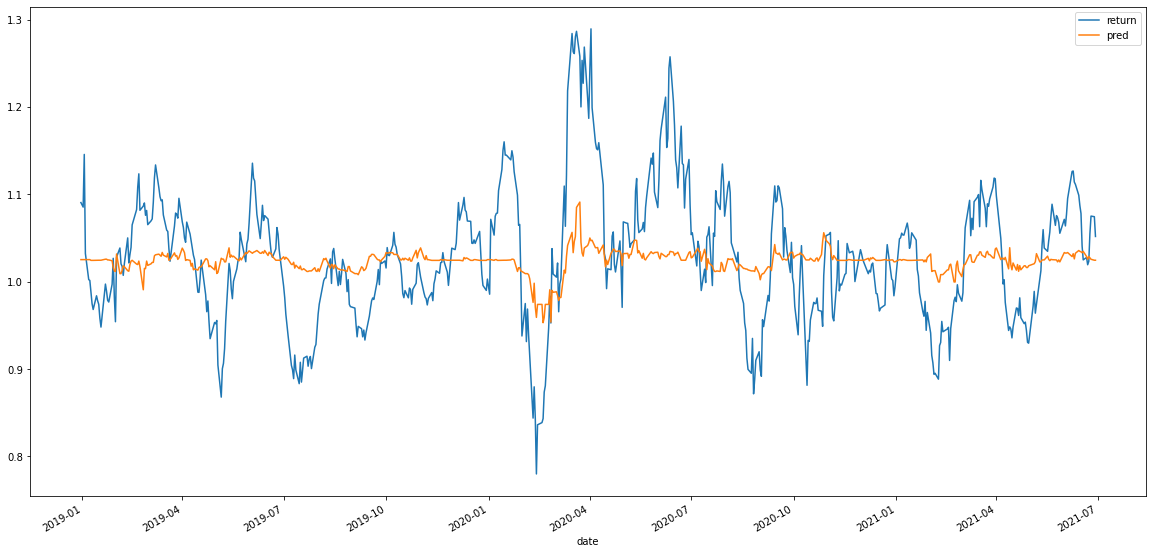

In [328]:
data_enc[data_enc.ticker=="AMZN"].plot(x="date",y=["return","pred"],figsize=(20,10))

In [330]:
test["pred"]=gbm.predict(test[gbm.feature_name()])

In [331]:
test

,date,ticker,Close,Volume,std_close,avg_close,std_pct,market_capitalisation,country,ipo_year,...,woy_enc,moy_enc,avg_hist_return,max_hist_return,min_hist_return,avg_hist_price,max_hist_price,min_hist_price,std_hist_price,pred
0,2021-10-01,A,155.990005,1881900.0,31.329370,102.415409,30.590485,4.603504e+10,United States,1999.0,...,38,9,1.025720,1.235099,0.742015,92.832000,148.809998,63.270000,22.207778,1.033975
1,2021-10-04,A,152.360001,1758300.0,31.329370,102.415409,30.590485,4.603504e+10,United States,1999.0,...,39,9,1.025720,1.235099,0.742015,92.832000,148.809998,63.270000,22.207778,1.027176
2,2021-10-05,A,153.029999,1494300.0,31.329370,102.415409,30.590485,4.603504e+10,United States,1999.0,...,39,9,1.025720,1.235099,0.742015,92.832000,148.809998,63.270000,22.207778,1.026432
3,2021-10-06,A,153.649994,1794700.0,31.329370,102.415409,30.590485,4.603504e+10,United States,1999.0,...,39,9,1.025720,1.235099,0.742015,92.832000,148.809998,63.270000,22.207778,1.026432
4,2021-10-07,A,155.320007,1002800.0,31.329370,102.415409,30.590485,4.603504e+10,United States,1999.0,...,39,9,1.025720,1.235099,0.742015,92.832000,148.809998,63.270000,22.207778,1.028386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17566,2021-10-22,ZTS,208.509995,1104400.0,34.579334,145.062384,23.837561,1.037660e+11,United States,2013.0,...,41,9,1.028731,1.374811,0.669557,134.980689,187.990005,81.559998,26.205028,1.025395
17567,2021-10-25,ZTS,211.520004,1224700.0,34.579334,145.062384,23.837561,1.037660e+11,United States,2013.0,...,42,9,1.028731,1.374811,0.669557,134.980689,187.990005,81.559998,26.205028,1.026911
17568,2021-10-26,ZTS,210.520004,1219300.0,34.579334,145.062384,23.837561,1.037660e+11,United States,2013.0,...,42,9,1.028731,1.374811,0.669557,134.980689,187.990005,81.559998,26.205028,1.026911
17569,2021-10-27,ZTS,209.580002,1625200.0,34.579334,145.062384,23.837561,1.037660e+11,United States,2013.0,...,42,9,1.028731,1.374811,0.669557,134.980689,187.990005,81.559998,26.205028,1.032081


In [347]:
def compute_metrics(data,model):
    test=data.copy()
    test["pred"]=model.predict(test[model.feature_name()])
    test["error"]=test.pred-test["return"]
    test["error_by_actuals"]=test["error"]/test.Close
    test["abs_error"]=test.error.abs()
    test["abs_error_by_actuals"]=test["abs_error"]/test.Close
    test["positive_actuals"]=test["return"].apply(lambda x:1 if x>1 else 0)
    test["positive_preds"]=test["pred"].apply(lambda x:1 if x>1 else 0)
    test["true_positive"]=test["positive_actuals"]*test["positive_preds"]
    test["negative_actuals"]=test["return"].apply(lambda x:1 if x<=1 else 0)
    test["negative_preds"]=test["pred"].apply(lambda x:1 if x<=1 else 0)
    test["true_negative"]=test["negative_actuals"]*test["negative_preds"]
    metrics=test.groupby("ticker",as_index=False).agg(
        avg_mk_cap=("market_capitalisation","mean"),
        std_stock=("Close","std"),
        mape=("abs_error_by_actuals",lambda x: np.round(100*np.average(x),2)),
        bias=("error_by_actuals",lambda x: np.round(100*np.average(x),2)),
        mae=("abs_error",lambda x: np.round(100*np.average(x),2)),
        cnt_true_pos=("true_positive","sum"),
        true_positivity=("true_positive",lambda x: np.round(100*np.sum(x)/len(x),2)),
        cnt_true_neg=("true_negative","sum"),
        true_negativity=("true_negative",lambda x: np.round(100*np.sum(x)/len(x),2))
    )
    return metrics

In [348]:
res=compute_metrics(test,gbm)

In [349]:
res.sort_values("cnt_true_neg")

,ticker,avg_mk_cap,std_stock,mape,bias,mae,cnt_true_pos,true_positivity,cnt_true_neg,true_negativity
0,A,4.603504e+10,2.970366,0.01,0.00,2.07,17,85.0,0,0.0
580,NWSA,1.270583e+10,0.338447,0.23,0.23,5.37,3,15.0,0,0.0
581,NXPI,5.649752e+10,5.513765,0.05,-0.05,9.21,20,100.0,0,0.0
582,O,3.930322e+10,2.423858,0.05,-0.02,3.11,17,85.0,0,0.0
583,ODFL,4.049083e+10,17.579684,0.05,-0.05,13.35,20,100.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
298,EXAS,1.472637e+10,1.819943,0.08,0.07,7.99,7,35.0,0,0.0
299,EXC,5.227152e+10,1.626027,0.13,-0.12,6.20,20,100.0,0,0.0
301,EXPE,2.421412e+10,3.564181,0.03,-0.01,5.70,14,70.0,0,0.0
879,ZTS,1.037660e+11,6.447403,0.03,-0.03,5.52,20,100.0,0,0.0


<AxesSubplot:xlabel='dow'>

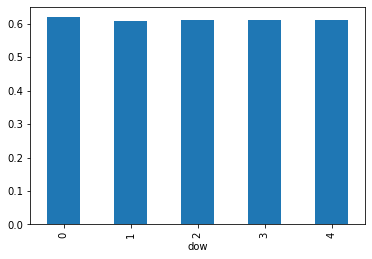

In [471]:
data_enc.groupby("dow").direction.mean().plot.bar()

In [ ]:
data_enc.groupby("woy_enc").direction.mean().plot.bar()